## Libraries

In [244]:
import tensorflow_datasets as tfds
import tensorflow as tf
from keras import models
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import keras.utils as image
from tensorflow.keras.applications.xception import preprocess_input
import os

## Loading data using Tensorflow Dataset

In [230]:
dataset, info = tfds.load("stanford_dogs", as_supervised=True, with_info=True)

In [9]:
dataset_size = info.splits["train"].num_examples
n_classes = info.features["label"].num_classes
class_names = info.features["label"].names

In [4]:
dataset_size, n_classes

(12000, 120)

Unfortunately, there are only "train" and "test: dataset, no validation set, so I need to split the training set. I will take the last 20% of the dataset for validation, and the remaining 80% for training:

In [3]:
train_set, valid_set, test_set = tfds.load(
    name="stanford_dogs",
    split=["train[:80%]", "train[80%:]", "test"],
    as_supervised=True
    )

## Transfor Learning : reusing a pretrained Inception model. 

In [6]:
tf.keras.backend.clear_session()

## Preprocessing

All three datasets contain individual images. I need to batch them, but first I need to ensure they all have the same size, or batching will fail. 

In [5]:
batch_size = 32
preprocess = tf.keras.Sequential([
    tf.keras.layers.Resizing(height=224, width=224, crop_to_aspect_ratio=True),
    tf.keras.layers.Lambda(tf.keras.applications.xception.preprocess_input)
])



### Data Augmentation

Create a data augmentation model that I will embed in the final model. During training, it will randomly flip the images horizontally, rotate them a little bit, and tweak the contrast:

This task is for object recognition tasks, so data augmentation of flipping and rotation may be an appropriate augmentation method

In [6]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip(mode="horizontal", seed=42),
    tf.keras.layers.RandomRotation(factor=0.05, seed=42)
])

In [7]:
train_set = (
    train_set
    .map(lambda x, y: (preprocess (x), y))
    .shuffle(batch_size * 100)
    .batch(batch_size)
    .map(lambda x, y: (data_augmentation(x), y),num_parallel_calls=tf.data.AUTOTUNE)
    .prefetch(tf.data.AUTOTUNE)
)


valid_set = (
    valid_set
    .map(lambda x, y: (preprocess (x), y))
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)


test_set = (
    test_set
    .map(lambda x, y: (preprocess (x), y))
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)

In [10]:
def num_pictures(set):
    num_pictures = 0
    for images, labels in set:
        num_pictures += images.shape[0]
    
    return(num_pictures)

print("Number of pictures in the train_set:", num_pictures(train_set))
print("Number of pictures in the valid_set:", num_pictures(valid_set))
print("Number of pictures in the test_set:", num_pictures(test_set))

Number of pictures in the train_set: 9600
Number of pictures in the valid_set: 2400
Number of pictures in the test_set: 8580


Number of images for each breed

In [20]:
breed_count_train = {}
for images, labels in train_set:
    for label in labels.numpy():
        if label not in breed_count_train :
            breed_count_train [label] = 1
        else:
            breed_count_train [label] += 1

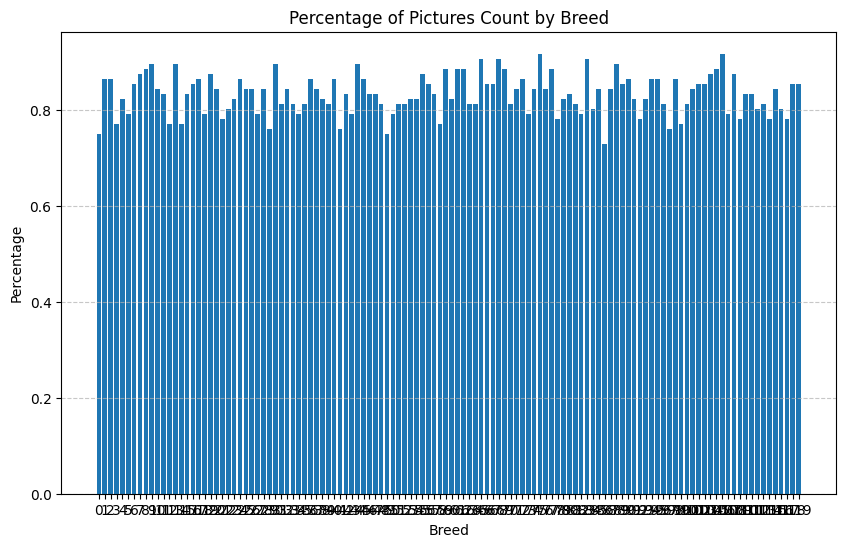

In [26]:

breed_counts_df_train = {}

for images, labels in train_set:
    for label in labels.numpy():
        breed_count_train[label] = breed_count_train.get(label, 0) + 1
    
breed_counts_df_train = pd.DataFrame(breed_count_train .items(), columns=["Breed", "Pictures Count"])

total_pictures = breed_counts_df_train['Pictures Count'].sum()

# Calculate the percentage for each breed and add it as a new column
breed_counts_df_train['Percentage'] = (breed_counts_df_train['Pictures Count'] / total_pictures) * 100

plt.figure(figsize=(10, 6))
plt.bar(breed_counts_df_train['Breed'], breed_counts_df_train['Percentage'])
plt.xlabel('Breed')
plt.ylabel('Percentage')
plt.title('Percentage of Pictures Count by Breed')
plt.xticks(breed_counts_df_train['Breed'])  
plt.grid(axis='y', linestyle='--', alpha=0.7)  
plt.show()


The amount of data for each breed is not too different.

Take a look at 9 images randomly from the train set: they're all 224x224 now, each batch contains 32 images with values ranging from -1 to 1, and with data augmentation:

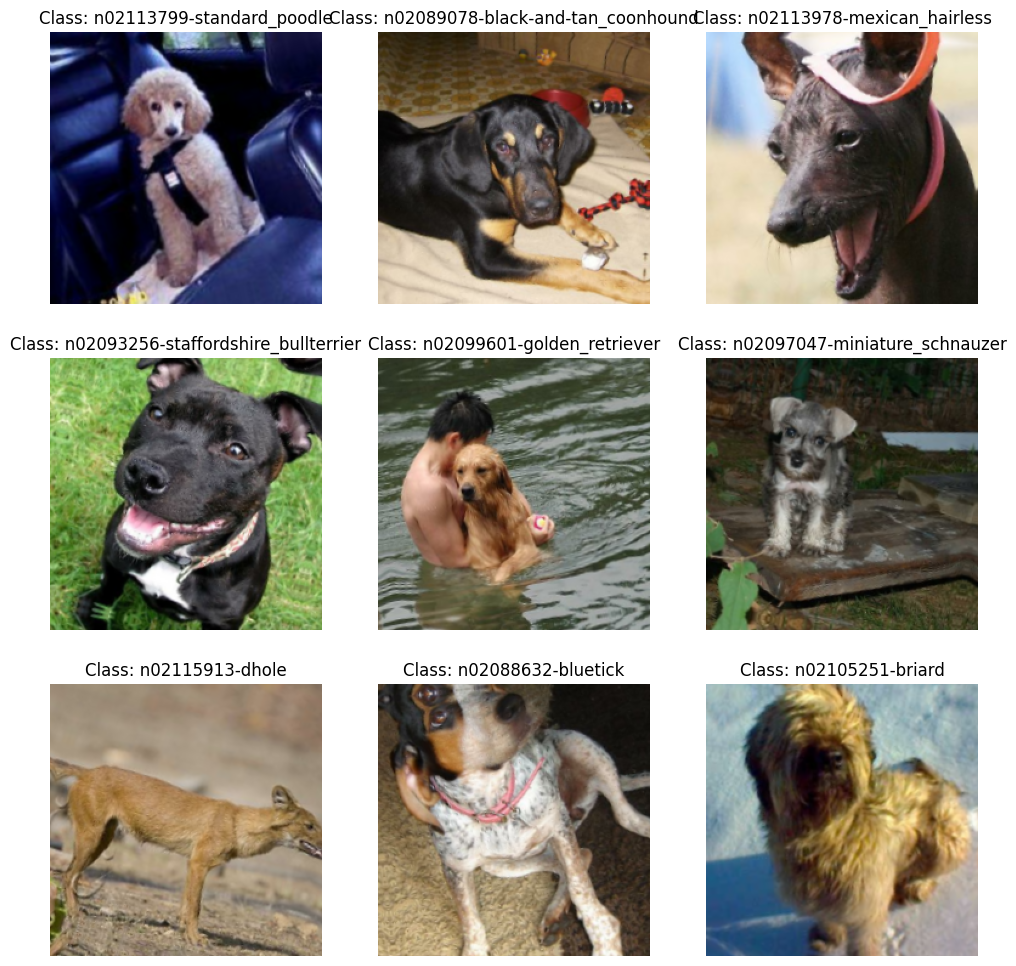

In [11]:
plt.figure(figsize=(12, 12))
for X_batch, y_batch in train_set.take(1):
    X_batch_augmented = data_augmentation(X_batch, training=True)
    for index in range(9):
        plt.subplot(3, 3, index + 1)
        # We must rescale the images to the 0-1 range for imshow(), and also
        # clip the result to that range, because data augmentation may
        # make some values go out of bounds (e.g., RandomContrast in this case).
        plt.imshow(np.clip((X_batch_augmented[index] + 1) / 2, 0, 1))
        plt.title(f"Class: {class_names[y_batch[index]]}")
        plt.axis("off")

plt.show()

## Modeling

I load an Xception model, pretrained on ImageNet, and exclude the top of the network by setting include_top=False(This excludes the global average pooling layer and the dense output layer). 

All of the trials use transfer learning with following: 

* Freeze the base model layers train for 5 epochs at 0.1 learning rate then unfreeze the layers for fine-tuning with early stoppping at 0.0001 learning rate. 

* Optimizar: SGD

* Batch Size : 32

### Trail number 0. Xception_0(Baseline Model)

* For my base model, I add global average pooling layer (feeding it the output of the original base model), followed by a dense output layer with one unit per class, using the softmax activation function. 

* For Trail number 0, I first freeze all the layers, and train a few epochs with a higher learning rate, and then unfreeze the top layer of the Xception base model for fine tuning with a much lower learning rate. 

In [13]:
base_model = tf.keras.applications.xception.Xception(weights="imagenet", include_top=False)

tf.random.set_seed(42)

#Average Pooling Layer
avg = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)

#Dense Output Layer
output = tf.keras.layers.Dense(n_classes, activation="softmax")(avg)

model = tf.keras.Model(inputs = base_model.input, outputs = output)

Freeze the weights of the pretrained layers at the beginning of training.

In [14]:
for layer in base_model.layers:
    layer.trainable = False

In [15]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 block1_conv1 (Conv2D)          (None, None, None,   864         ['input_1[0][0]']                
                                32)                                                               
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, None, None,   128        ['block1_conv1[0][0]']           
 ation)                         32)                                                           

In [113]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.9)
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=["accuracy"])

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("xception_checkpoints_base", save_best_only=True)
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

history = model.fit(train_set, validation_data=valid_set, epochs=5, callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/5
300/300 [==============================] - ETA: 0s - loss: 1.3009 - accuracy: 0.7210

INFO:tensorflow:Assets written to: xception_checkpoints_base\assets


INFO:tensorflow:Assets written to: xception_checkpoints_base\assets


300/300 [==============================] - 493s 2s/step - loss: 1.3009 - accuracy: 0.7210 - val_loss: 0.9493 - val_accuracy: 0.8037
Epoch 2/5
300/300 [==============================] - 405s 1s/step - loss: 0.8327 - accuracy: 0.8142 - val_loss: 1.0390 - val_accuracy: 0.7979
Epoch 3/5
300/300 [==============================] - 405s 1s/step - loss: 0.6534 - accuracy: 0.8457 - val_loss: 1.0670 - val_accuracy: 0.8029
Epoch 4/5
300/300 [==============================] - 404s 1s/step - loss: 0.5620 - accuracy: 0.8625 - val_loss: 0.9714 - val_accuracy: 0.8167
Epoch 5/5
300/300 [==============================] - ETA: 0s - loss: 0.4675 - accuracy: 0.8831

INFO:tensorflow:Assets written to: xception_checkpoints_base\assets


INFO:tensorflow:Assets written to: xception_checkpoints_base\assets


300/300 [==============================] - 415s 1s/step - loss: 0.4675 - accuracy: 0.8831 - val_loss: 0.9183 - val_accuracy: 0.8196


In [114]:
model.save("xception_base", save_format = "tf")

INFO:tensorflow:Assets written to: xception_base\assets


INFO:tensorflow:Assets written to: xception_base\assets


 Fine-Tuning
 
 The top layers are now pretty well trained, and I am ready to unfreeze some of the base model’s top layers, then continue training. I will unfreeze layers 116 and above (that’s the start of residual unit 13 out of 14) and use a much lower learning rate

In [18]:
for indices in zip(range(33), range(33, 66), range(66, 99), range(99, 132)):
    for idx in indices:
        print(f"{idx:3}: {base_model.layers[idx].name:22}", end="")
    print()

  0: input_1                33: block4_pool            66: block8_sepconv1_act    99: block11_sepconv2_act  
  1: block1_conv1           34: batch_normalization_2  67: block8_sepconv1       100: block11_sepconv2      
  2: block1_conv1_bn        35: add_2                  68: block8_sepconv1_bn    101: block11_sepconv2_bn   
  3: block1_conv1_act       36: block5_sepconv1_act    69: block8_sepconv2_act   102: block11_sepconv3_act  
  4: block1_conv2           37: block5_sepconv1        70: block8_sepconv2       103: block11_sepconv3      
  5: block1_conv2_bn        38: block5_sepconv1_bn     71: block8_sepconv2_bn    104: block11_sepconv3_bn   
  6: block1_conv2_act       39: block5_sepconv2_act    72: block8_sepconv3_act   105: add_9                 
  7: block2_sepconv1        40: block5_sepconv2        73: block8_sepconv3       106: block12_sepconv1_act  
  8: block2_sepconv1_bn     41: block5_sepconv2_bn     74: block8_sepconv3_bn    107: block12_sepconv1      
  9: block2_sepconv

In [16]:
model = tf.keras.models.load_model("xception_base")

In [17]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 block1_conv1 (Conv2D)          (None, None, None,   864         ['input_1[0][0]']                
                                32)                                                               
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, None, None,   128        ['block1_conv1[0][0]']           
 ation)                         32)                                                           

In [19]:
for layer in base_model.layers[116:]:
    if not isinstance(layer, tf.keras.layers.BatchNormalization): #Nornalization layer need to remain frozen
        layer.trainable = True

In [20]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.0001, momentum=0.9)
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=["accuracy"])

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("xception_checkpoints0", save_best_only=True)
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

history = model.fit(train_set, validation_data=valid_set, epochs=50, callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/50
300/300 [==============================] - ETA: 0s - loss: 0.3220 - accuracy: 0.9107

INFO:tensorflow:Assets written to: xception_checkpoints0\assets


INFO:tensorflow:Assets written to: xception_checkpoints0\assets


300/300 [==============================] - 451s 1s/step - loss: 0.3220 - accuracy: 0.9107 - val_loss: 0.9063 - val_accuracy: 0.8213
Epoch 2/50
300/300 [==============================] - ETA: 0s - loss: 0.3008 - accuracy: 0.9137

INFO:tensorflow:Assets written to: xception_checkpoints0\assets


INFO:tensorflow:Assets written to: xception_checkpoints0\assets


300/300 [==============================] - 451s 1s/step - loss: 0.3008 - accuracy: 0.9137 - val_loss: 0.8956 - val_accuracy: 0.8221
Epoch 3/50
300/300 [==============================] - ETA: 0s - loss: 0.3009 - accuracy: 0.9135

INFO:tensorflow:Assets written to: xception_checkpoints0\assets


INFO:tensorflow:Assets written to: xception_checkpoints0\assets


300/300 [==============================] - 393s 1s/step - loss: 0.3009 - accuracy: 0.9135 - val_loss: 0.8852 - val_accuracy: 0.8221
Epoch 4/50
300/300 [==============================] - ETA: 0s - loss: 0.3032 - accuracy: 0.9157

INFO:tensorflow:Assets written to: xception_checkpoints0\assets


INFO:tensorflow:Assets written to: xception_checkpoints0\assets


300/300 [==============================] - 488s 2s/step - loss: 0.3032 - accuracy: 0.9157 - val_loss: 0.8756 - val_accuracy: 0.8221
Epoch 5/50
300/300 [==============================] - ETA: 0s - loss: 0.2849 - accuracy: 0.9171

INFO:tensorflow:Assets written to: xception_checkpoints0\assets


INFO:tensorflow:Assets written to: xception_checkpoints0\assets


300/300 [==============================] - 373s 1s/step - loss: 0.2849 - accuracy: 0.9171 - val_loss: 0.8668 - val_accuracy: 0.8246
Epoch 6/50
300/300 [==============================] - ETA: 0s - loss: 0.2734 - accuracy: 0.9219

INFO:tensorflow:Assets written to: xception_checkpoints0\assets


INFO:tensorflow:Assets written to: xception_checkpoints0\assets


300/300 [==============================] - 353s 1s/step - loss: 0.2734 - accuracy: 0.9219 - val_loss: 0.8587 - val_accuracy: 0.8254
Epoch 7/50
300/300 [==============================] - ETA: 0s - loss: 0.2791 - accuracy: 0.9223

INFO:tensorflow:Assets written to: xception_checkpoints0\assets


INFO:tensorflow:Assets written to: xception_checkpoints0\assets


300/300 [==============================] - 746s 2s/step - loss: 0.2791 - accuracy: 0.9223 - val_loss: 0.8511 - val_accuracy: 0.8263
Epoch 8/50
300/300 [==============================] - ETA: 0s - loss: 0.2645 - accuracy: 0.9226

INFO:tensorflow:Assets written to: xception_checkpoints0\assets


INFO:tensorflow:Assets written to: xception_checkpoints0\assets


300/300 [==============================] - 365s 1s/step - loss: 0.2645 - accuracy: 0.9226 - val_loss: 0.8439 - val_accuracy: 0.8300
Epoch 9/50
300/300 [==============================] - ETA: 0s - loss: 0.2593 - accuracy: 0.9249

INFO:tensorflow:Assets written to: xception_checkpoints0\assets


INFO:tensorflow:Assets written to: xception_checkpoints0\assets


300/300 [==============================] - 792s 3s/step - loss: 0.2593 - accuracy: 0.9249 - val_loss: 0.8373 - val_accuracy: 0.8308
Epoch 10/50
300/300 [==============================] - ETA: 0s - loss: 0.2481 - accuracy: 0.9264

INFO:tensorflow:Assets written to: xception_checkpoints0\assets


INFO:tensorflow:Assets written to: xception_checkpoints0\assets


300/300 [==============================] - 376s 1s/step - loss: 0.2481 - accuracy: 0.9264 - val_loss: 0.8315 - val_accuracy: 0.8313
Epoch 11/50
300/300 [==============================] - ETA: 0s - loss: 0.2514 - accuracy: 0.9236

INFO:tensorflow:Assets written to: xception_checkpoints0\assets


INFO:tensorflow:Assets written to: xception_checkpoints0\assets


300/300 [==============================] - 364s 1s/step - loss: 0.2514 - accuracy: 0.9236 - val_loss: 0.8256 - val_accuracy: 0.8325
Epoch 12/50
300/300 [==============================] - ETA: 0s - loss: 0.2500 - accuracy: 0.9243

INFO:tensorflow:Assets written to: xception_checkpoints0\assets


INFO:tensorflow:Assets written to: xception_checkpoints0\assets


300/300 [==============================] - 368s 1s/step - loss: 0.2500 - accuracy: 0.9243 - val_loss: 0.8200 - val_accuracy: 0.8338
Epoch 13/50
300/300 [==============================] - ETA: 0s - loss: 0.2449 - accuracy: 0.9248

INFO:tensorflow:Assets written to: xception_checkpoints0\assets


INFO:tensorflow:Assets written to: xception_checkpoints0\assets


300/300 [==============================] - 374s 1s/step - loss: 0.2449 - accuracy: 0.9248 - val_loss: 0.8148 - val_accuracy: 0.8346
Epoch 14/50
300/300 [==============================] - ETA: 0s - loss: 0.2321 - accuracy: 0.9287

INFO:tensorflow:Assets written to: xception_checkpoints0\assets


INFO:tensorflow:Assets written to: xception_checkpoints0\assets


300/300 [==============================] - 372s 1s/step - loss: 0.2321 - accuracy: 0.9287 - val_loss: 0.8100 - val_accuracy: 0.8350
Epoch 15/50
300/300 [==============================] - ETA: 0s - loss: 0.2377 - accuracy: 0.9280

INFO:tensorflow:Assets written to: xception_checkpoints0\assets


INFO:tensorflow:Assets written to: xception_checkpoints0\assets


300/300 [==============================] - 361s 1s/step - loss: 0.2377 - accuracy: 0.9280 - val_loss: 0.8055 - val_accuracy: 0.8350
Epoch 16/50
300/300 [==============================] - ETA: 0s - loss: 0.2203 - accuracy: 0.9309

INFO:tensorflow:Assets written to: xception_checkpoints0\assets


INFO:tensorflow:Assets written to: xception_checkpoints0\assets


300/300 [==============================] - 374s 1s/step - loss: 0.2203 - accuracy: 0.9309 - val_loss: 0.8014 - val_accuracy: 0.8346
Epoch 17/50
300/300 [==============================] - ETA: 0s - loss: 0.2370 - accuracy: 0.9275

INFO:tensorflow:Assets written to: xception_checkpoints0\assets


INFO:tensorflow:Assets written to: xception_checkpoints0\assets


300/300 [==============================] - 381s 1s/step - loss: 0.2370 - accuracy: 0.9275 - val_loss: 0.7973 - val_accuracy: 0.8346
Epoch 18/50
300/300 [==============================] - ETA: 0s - loss: 0.2269 - accuracy: 0.9321

INFO:tensorflow:Assets written to: xception_checkpoints0\assets


INFO:tensorflow:Assets written to: xception_checkpoints0\assets


300/300 [==============================] - 372s 1s/step - loss: 0.2269 - accuracy: 0.9321 - val_loss: 0.7936 - val_accuracy: 0.8350
Epoch 19/50
300/300 [==============================] - ETA: 0s - loss: 0.2161 - accuracy: 0.9333

INFO:tensorflow:Assets written to: xception_checkpoints0\assets


INFO:tensorflow:Assets written to: xception_checkpoints0\assets


300/300 [==============================] - 637s 2s/step - loss: 0.2161 - accuracy: 0.9333 - val_loss: 0.7903 - val_accuracy: 0.8350
Epoch 20/50
300/300 [==============================] - ETA: 0s - loss: 0.2261 - accuracy: 0.9286

INFO:tensorflow:Assets written to: xception_checkpoints0\assets


INFO:tensorflow:Assets written to: xception_checkpoints0\assets


300/300 [==============================] - 358s 1s/step - loss: 0.2261 - accuracy: 0.9286 - val_loss: 0.7871 - val_accuracy: 0.8350
Epoch 21/50
300/300 [==============================] - ETA: 0s - loss: 0.2110 - accuracy: 0.9327

INFO:tensorflow:Assets written to: xception_checkpoints0\assets


INFO:tensorflow:Assets written to: xception_checkpoints0\assets


300/300 [==============================] - 371s 1s/step - loss: 0.2110 - accuracy: 0.9327 - val_loss: 0.7842 - val_accuracy: 0.8354
Epoch 22/50
300/300 [==============================] - ETA: 0s - loss: 0.2103 - accuracy: 0.9357

INFO:tensorflow:Assets written to: xception_checkpoints0\assets


INFO:tensorflow:Assets written to: xception_checkpoints0\assets


300/300 [==============================] - 566s 2s/step - loss: 0.2103 - accuracy: 0.9357 - val_loss: 0.7815 - val_accuracy: 0.8363
Epoch 23/50
300/300 [==============================] - ETA: 0s - loss: 0.2115 - accuracy: 0.9350

INFO:tensorflow:Assets written to: xception_checkpoints0\assets


INFO:tensorflow:Assets written to: xception_checkpoints0\assets


300/300 [==============================] - 371s 1s/step - loss: 0.2115 - accuracy: 0.9350 - val_loss: 0.7790 - val_accuracy: 0.8367
Epoch 24/50
300/300 [==============================] - ETA: 0s - loss: 0.2117 - accuracy: 0.9345

INFO:tensorflow:Assets written to: xception_checkpoints0\assets


INFO:tensorflow:Assets written to: xception_checkpoints0\assets


300/300 [==============================] - 377s 1s/step - loss: 0.2117 - accuracy: 0.9345 - val_loss: 0.7765 - val_accuracy: 0.8367
Epoch 25/50
300/300 [==============================] - ETA: 0s - loss: 0.2012 - accuracy: 0.9381

INFO:tensorflow:Assets written to: xception_checkpoints0\assets


INFO:tensorflow:Assets written to: xception_checkpoints0\assets


300/300 [==============================] - 377s 1s/step - loss: 0.2012 - accuracy: 0.9381 - val_loss: 0.7742 - val_accuracy: 0.8383
Epoch 26/50
300/300 [==============================] - ETA: 0s - loss: 0.2058 - accuracy: 0.9356

INFO:tensorflow:Assets written to: xception_checkpoints0\assets


INFO:tensorflow:Assets written to: xception_checkpoints0\assets


300/300 [==============================] - 376s 1s/step - loss: 0.2058 - accuracy: 0.9356 - val_loss: 0.7720 - val_accuracy: 0.8388
Epoch 27/50
300/300 [==============================] - ETA: 0s - loss: 0.2052 - accuracy: 0.9355

INFO:tensorflow:Assets written to: xception_checkpoints0\assets


INFO:tensorflow:Assets written to: xception_checkpoints0\assets


300/300 [==============================] - 378s 1s/step - loss: 0.2052 - accuracy: 0.9355 - val_loss: 0.7699 - val_accuracy: 0.8392
Epoch 28/50
300/300 [==============================] - ETA: 0s - loss: 0.1967 - accuracy: 0.9361

INFO:tensorflow:Assets written to: xception_checkpoints0\assets


INFO:tensorflow:Assets written to: xception_checkpoints0\assets


300/300 [==============================] - 372s 1s/step - loss: 0.1967 - accuracy: 0.9361 - val_loss: 0.7678 - val_accuracy: 0.8392
Epoch 29/50
300/300 [==============================] - ETA: 0s - loss: 0.2029 - accuracy: 0.9351

INFO:tensorflow:Assets written to: xception_checkpoints0\assets


INFO:tensorflow:Assets written to: xception_checkpoints0\assets


300/300 [==============================] - 385s 1s/step - loss: 0.2029 - accuracy: 0.9351 - val_loss: 0.7658 - val_accuracy: 0.8396
Epoch 30/50
300/300 [==============================] - ETA: 0s - loss: 0.2023 - accuracy: 0.9360

INFO:tensorflow:Assets written to: xception_checkpoints0\assets


INFO:tensorflow:Assets written to: xception_checkpoints0\assets


300/300 [==============================] - 393s 1s/step - loss: 0.2023 - accuracy: 0.9360 - val_loss: 0.7640 - val_accuracy: 0.8400
Epoch 31/50
300/300 [==============================] - ETA: 0s - loss: 0.2054 - accuracy: 0.9352

INFO:tensorflow:Assets written to: xception_checkpoints0\assets


INFO:tensorflow:Assets written to: xception_checkpoints0\assets


300/300 [==============================] - 394s 1s/step - loss: 0.2054 - accuracy: 0.9352 - val_loss: 0.7623 - val_accuracy: 0.8400
Epoch 32/50
300/300 [==============================] - ETA: 0s - loss: 0.1920 - accuracy: 0.9390

INFO:tensorflow:Assets written to: xception_checkpoints0\assets


INFO:tensorflow:Assets written to: xception_checkpoints0\assets


300/300 [==============================] - 397s 1s/step - loss: 0.1920 - accuracy: 0.9390 - val_loss: 0.7606 - val_accuracy: 0.8404
Epoch 33/50
300/300 [==============================] - ETA: 0s - loss: 0.1897 - accuracy: 0.9382

INFO:tensorflow:Assets written to: xception_checkpoints0\assets


INFO:tensorflow:Assets written to: xception_checkpoints0\assets


300/300 [==============================] - 395s 1s/step - loss: 0.1897 - accuracy: 0.9382 - val_loss: 0.7592 - val_accuracy: 0.8408
Epoch 34/50
300/300 [==============================] - ETA: 0s - loss: 0.1851 - accuracy: 0.9400

INFO:tensorflow:Assets written to: xception_checkpoints0\assets


INFO:tensorflow:Assets written to: xception_checkpoints0\assets


300/300 [==============================] - 400s 1s/step - loss: 0.1851 - accuracy: 0.9400 - val_loss: 0.7575 - val_accuracy: 0.8413
Epoch 35/50
300/300 [==============================] - ETA: 0s - loss: 0.1928 - accuracy: 0.9400

INFO:tensorflow:Assets written to: xception_checkpoints0\assets


INFO:tensorflow:Assets written to: xception_checkpoints0\assets


300/300 [==============================] - 400s 1s/step - loss: 0.1928 - accuracy: 0.9400 - val_loss: 0.7560 - val_accuracy: 0.8408
Epoch 36/50
300/300 [==============================] - ETA: 0s - loss: 0.1903 - accuracy: 0.9399

INFO:tensorflow:Assets written to: xception_checkpoints0\assets


INFO:tensorflow:Assets written to: xception_checkpoints0\assets


300/300 [==============================] - 389s 1s/step - loss: 0.1903 - accuracy: 0.9399 - val_loss: 0.7545 - val_accuracy: 0.8408
Epoch 37/50
300/300 [==============================] - ETA: 0s - loss: 0.1881 - accuracy: 0.9402

INFO:tensorflow:Assets written to: xception_checkpoints0\assets


INFO:tensorflow:Assets written to: xception_checkpoints0\assets


300/300 [==============================] - 378s 1s/step - loss: 0.1881 - accuracy: 0.9402 - val_loss: 0.7534 - val_accuracy: 0.8413
Epoch 38/50
300/300 [==============================] - ETA: 0s - loss: 0.1817 - accuracy: 0.9396

INFO:tensorflow:Assets written to: xception_checkpoints0\assets


INFO:tensorflow:Assets written to: xception_checkpoints0\assets


300/300 [==============================] - 387s 1s/step - loss: 0.1817 - accuracy: 0.9396 - val_loss: 0.7523 - val_accuracy: 0.8413
Epoch 39/50
300/300 [==============================] - ETA: 0s - loss: 0.1934 - accuracy: 0.9389

INFO:tensorflow:Assets written to: xception_checkpoints0\assets


INFO:tensorflow:Assets written to: xception_checkpoints0\assets


300/300 [==============================] - 400s 1s/step - loss: 0.1934 - accuracy: 0.9389 - val_loss: 0.7509 - val_accuracy: 0.8429
Epoch 40/50
300/300 [==============================] - ETA: 0s - loss: 0.1833 - accuracy: 0.9404

INFO:tensorflow:Assets written to: xception_checkpoints0\assets


INFO:tensorflow:Assets written to: xception_checkpoints0\assets


300/300 [==============================] - 858s 3s/step - loss: 0.1833 - accuracy: 0.9404 - val_loss: 0.7496 - val_accuracy: 0.8429
Epoch 41/50
300/300 [==============================] - ETA: 0s - loss: 0.1893 - accuracy: 0.9405

INFO:tensorflow:Assets written to: xception_checkpoints0\assets


INFO:tensorflow:Assets written to: xception_checkpoints0\assets


300/300 [==============================] - 1039s 3s/step - loss: 0.1893 - accuracy: 0.9405 - val_loss: 0.7486 - val_accuracy: 0.8442
Epoch 42/50
300/300 [==============================] - ETA: 0s - loss: 0.1846 - accuracy: 0.9407

INFO:tensorflow:Assets written to: xception_checkpoints0\assets


INFO:tensorflow:Assets written to: xception_checkpoints0\assets


300/300 [==============================] - 883s 3s/step - loss: 0.1846 - accuracy: 0.9407 - val_loss: 0.7475 - val_accuracy: 0.8450
Epoch 43/50
300/300 [==============================] - ETA: 0s - loss: 0.1829 - accuracy: 0.9397

INFO:tensorflow:Assets written to: xception_checkpoints0\assets


INFO:tensorflow:Assets written to: xception_checkpoints0\assets


300/300 [==============================] - 835s 3s/step - loss: 0.1829 - accuracy: 0.9397 - val_loss: 0.7465 - val_accuracy: 0.8446
Epoch 44/50
300/300 [==============================] - ETA: 0s - loss: 0.1865 - accuracy: 0.9402

INFO:tensorflow:Assets written to: xception_checkpoints0\assets


INFO:tensorflow:Assets written to: xception_checkpoints0\assets


300/300 [==============================] - 474s 2s/step - loss: 0.1865 - accuracy: 0.9402 - val_loss: 0.7453 - val_accuracy: 0.8446
Epoch 45/50
300/300 [==============================] - ETA: 0s - loss: 0.1879 - accuracy: 0.9413

INFO:tensorflow:Assets written to: xception_checkpoints0\assets


INFO:tensorflow:Assets written to: xception_checkpoints0\assets


300/300 [==============================] - 381s 1s/step - loss: 0.1879 - accuracy: 0.9413 - val_loss: 0.7442 - val_accuracy: 0.8454
Epoch 46/50
300/300 [==============================] - ETA: 0s - loss: 0.1794 - accuracy: 0.9404

INFO:tensorflow:Assets written to: xception_checkpoints0\assets


INFO:tensorflow:Assets written to: xception_checkpoints0\assets


300/300 [==============================] - 390s 1s/step - loss: 0.1794 - accuracy: 0.9404 - val_loss: 0.7433 - val_accuracy: 0.8458
Epoch 47/50
300/300 [==============================] - ETA: 0s - loss: 0.1831 - accuracy: 0.9413

INFO:tensorflow:Assets written to: xception_checkpoints0\assets


INFO:tensorflow:Assets written to: xception_checkpoints0\assets


300/300 [==============================] - 779s 3s/step - loss: 0.1831 - accuracy: 0.9413 - val_loss: 0.7423 - val_accuracy: 0.8454
Epoch 48/50
300/300 [==============================] - ETA: 0s - loss: 0.1818 - accuracy: 0.9435

INFO:tensorflow:Assets written to: xception_checkpoints0\assets


INFO:tensorflow:Assets written to: xception_checkpoints0\assets


300/300 [==============================] - 1041s 3s/step - loss: 0.1818 - accuracy: 0.9435 - val_loss: 0.7413 - val_accuracy: 0.8454
Epoch 49/50
300/300 [==============================] - ETA: 0s - loss: 0.1810 - accuracy: 0.9411

INFO:tensorflow:Assets written to: xception_checkpoints0\assets


INFO:tensorflow:Assets written to: xception_checkpoints0\assets


300/300 [==============================] - 1072s 4s/step - loss: 0.1810 - accuracy: 0.9411 - val_loss: 0.7406 - val_accuracy: 0.8454
Epoch 50/50
300/300 [==============================] - ETA: 0s - loss: 0.1819 - accuracy: 0.9405

INFO:tensorflow:Assets written to: xception_checkpoints0\assets


INFO:tensorflow:Assets written to: xception_checkpoints0\assets


300/300 [==============================] - 1072s 4s/step - loss: 0.1819 - accuracy: 0.9405 - val_loss: 0.7397 - val_accuracy: 0.8458


In [21]:
model.save("xception_0", save_format = "tf")

INFO:tensorflow:Assets written to: xception_0\assets


INFO:tensorflow:Assets written to: xception_0\assets


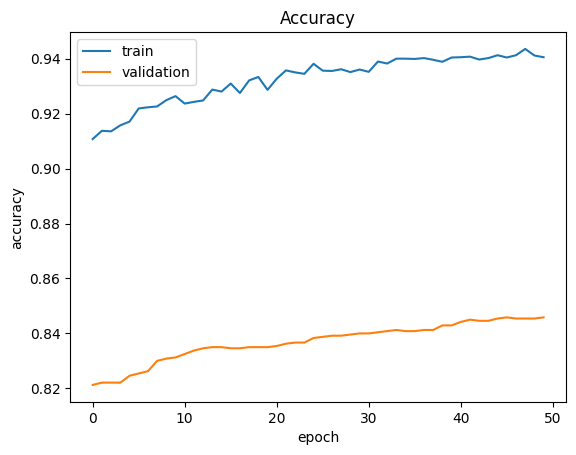

In [24]:
def plot_hist(hist):
    plt.plot(hist.history['accuracy'])
    plt.plot(hist.history['val_accuracy'])
    plt.title('Accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

plot_hist(history)

The base-line model already fit pretty well, but I am going to try different fine-tuning methods. 

---

### Trail number 1. Xception_1

* For Trail number 1, I directly use the model (xception_base) trained for 5 epochs before the trail 0 fine-tuning stage, but in the fine-tuning stage this time I unfreeze more xception layers.

In [115]:
model = tf.keras.models.load_model("xception_base")#Load the base model I trained for 5 epochs earlier, the top layers are already well trained

 Fine-Tuning
 
 I will unfreeze layers 56 and above this time (that’s the start of residual unit 7 out of 14).

In [116]:
for layer in model.layers[56:]:
    if not isinstance(layer, tf.keras.layers.BatchNormalization): #Nornalization layer need to remain frozen
        layer.trainable = True

In [118]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.0001, momentum=0.9)
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=["accuracy"])

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("xception_checkpoints_1", save_best_only=True)
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

history = model.fit(train_set, validation_data=valid_set, epochs=30, callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/30
300/300 [==============================] - ETA: 0s - loss: 0.2186 - accuracy: 0.9302

INFO:tensorflow:Assets written to: xception_checkpoints_1\assets


INFO:tensorflow:Assets written to: xception_checkpoints_1\assets


300/300 [==============================] - 1016s 3s/step - loss: 0.2186 - accuracy: 0.9302 - val_loss: 0.6552 - val_accuracy: 0.8396
Epoch 2/30
300/300 [==============================] - ETA: 0s - loss: 0.1573 - accuracy: 0.9493

INFO:tensorflow:Assets written to: xception_checkpoints_1\assets


INFO:tensorflow:Assets written to: xception_checkpoints_1\assets


300/300 [==============================] - 1215s 4s/step - loss: 0.1573 - accuracy: 0.9493 - val_loss: 0.6328 - val_accuracy: 0.8438
Epoch 3/30
300/300 [==============================] - 1182s 4s/step - loss: 0.1451 - accuracy: 0.9505 - val_loss: 0.6340 - val_accuracy: 0.8475
Epoch 4/30
300/300 [==============================] - 1192s 4s/step - loss: 0.1323 - accuracy: 0.9564 - val_loss: 0.6381 - val_accuracy: 0.8471
Epoch 5/30
300/300 [==============================] - 1188s 4s/step - loss: 0.1196 - accuracy: 0.9592 - val_loss: 0.6460 - val_accuracy: 0.8500
Epoch 6/30
300/300 [==============================] - 1183s 4s/step - loss: 0.1070 - accuracy: 0.9616 - val_loss: 0.6557 - val_accuracy: 0.8475
Epoch 7/30
300/300 [==============================] - 1205s 4s/step - loss: 0.0977 - accuracy: 0.9663 - val_loss: 0.6592 - val_accuracy: 0.8467
Epoch 8/30
300/300 [==============================] - 1191s 4s/step - loss: 0.0971 - accuracy: 0.9683 - val_loss: 0.6687 - val_accuracy: 0.8438
Epo

In [119]:
model.save("xception_1", save_format = "tf")

INFO:tensorflow:Assets written to: xception_1\assets


INFO:tensorflow:Assets written to: xception_1\assets


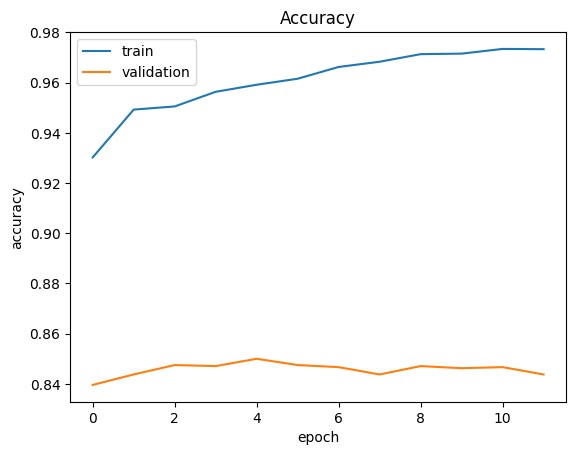

In [120]:
def plot_hist(hist):
    plt.plot(hist.history['accuracy'])
    plt.plot(hist.history['val_accuracy'])
    plt.title('Accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

plot_hist(history)

It looks like the model is overfitting.

----

### Trail number 2. Xception_2

* For Trail number 2, I decide to try adding more layers on top of the base model.

In [179]:
tf.keras.backend.clear_session()

In [59]:
tf.random.set_seed(42)

#Xception Model
base_model = tf.keras.applications.xception.Xception(weights="imagenet", include_top=False)

model = tf.keras.models.Sequential()
model.add(base_model)

#Average Pooling Layer
model.add(tf.keras.layers.GlobalAveragePooling2D())

# flatten to 1-D vector to prepare for fully connected layers
model.add(tf.keras.layers.Flatten()) 

#Dropout Layer
model.add(tf.keras.layers.Dropout(0.3))

#Dense Layer
model.add(tf.keras.layers.Dense(512, activation= "relu"))
model.add(tf.keras.layers.Dense(512, activation= "relu"))

#Output Layer
model.add(tf.keras.layers.Dense(n_classes, activation="softmax"))

print('Number of trainable weights before freezing the base layer:', len(model.trainable_weights))

# Freeze pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

print('Number of trainable weights after freezing the base layer:', len(model.trainable_weights))

Number of trainable weights before freezing the base layer: 160
Number of trainable weights after freezing the base layer: 6


In [61]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.9)
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=["accuracy"])

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("xception_checkpoints2", save_best_only=True)
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

history = model.fit(train_set, validation_data=valid_set, epochs=5, callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/5
300/300 [==============================] - ETA: 0s - loss: 1.7986 - accuracy: 0.5763

INFO:tensorflow:Assets written to: xception_checkpoints2\assets


INFO:tensorflow:Assets written to: xception_checkpoints2\assets


300/300 [==============================] - 374s 1s/step - loss: 1.7986 - accuracy: 0.5763 - val_loss: 1.1034 - val_accuracy: 0.7167
Epoch 2/5
300/300 [==============================] - 406s 1s/step - loss: 1.4874 - accuracy: 0.6662 - val_loss: 1.2308 - val_accuracy: 0.7246
Epoch 3/5
300/300 [==============================] - 484s 2s/step - loss: 1.5455 - accuracy: 0.6769 - val_loss: 1.6359 - val_accuracy: 0.6712
Epoch 4/5
300/300 [==============================] - 777s 3s/step - loss: 1.7251 - accuracy: 0.6646 - val_loss: 1.8450 - val_accuracy: 0.6492
Epoch 5/5
300/300 [==============================] - 910s 3s/step - loss: 1.8333 - accuracy: 0.6627 - val_loss: 1.5905 - val_accuracy: 0.7050


In [68]:
model.save("xception_2", save_format = "tf")

INFO:tensorflow:Assets written to: xception_2\assets


INFO:tensorflow:Assets written to: xception_2\assets


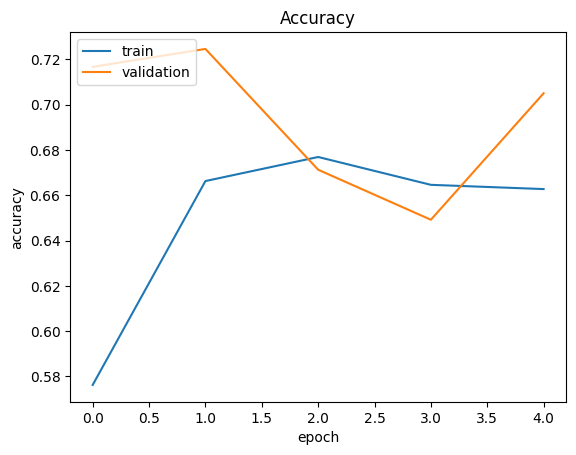

In [62]:
def plot_hist(hist):
    plt.plot(hist.history['accuracy'])
    plt.plot(hist.history['val_accuracy'])
    plt.title('Accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

plot_hist(history)

The model seems to have serious underfitting, so I don't plan to do fine-tunning

 
Say we have a network f(x) that has achieved an accuracy of n% on a data-set. Now adding more layers to this network g(f(x)) should have at least an accuracy of n% i.e. in the worst case g(.) should be an identical mapping yielding the same accuracy as that of f(x) if not more. But unfortunately, that is not the case. Experiments have shown that the accuracy decreases by adding more layers to the network. The issue is because of the vanishing gradient problem. As making the CNN deeper, the derivative when back-propagating to the initial layers becomes almost insignificant in value.

---

### Trail number 3. Xception_3

* For Trail number 3, I decide to try adding more layers on top of the base model and avoid vanishing gradient problem by adding batch normalization layers.

In [26]:
tf.keras.backend.clear_session()

In [27]:
tf.random.set_seed(42)

#Xception Model
base_model = tf.keras.applications.xception.Xception(weights="imagenet", include_top=False)

model = tf.keras.models.Sequential()
model.add(base_model)

#Average Pooling Layer
model.add(tf.keras.layers.GlobalAveragePooling2D())

# flatten to 1-D vector to prepare for fully connected layers
model.add(tf.keras.layers.Flatten()) 

#BatchNormalization
model.add(tf.keras.layers.BatchNormalization())

#Dense Layer
model.add(tf.keras.layers.Dense(512, activation= "relu"))

#BatchNormalization
model.add(tf.keras.layers.BatchNormalization())

#Dense Layer
model.add(tf.keras.layers.Dense(512, activation= "relu"))

#Output Layer
model.add(tf.keras.layers.Dense(n_classes, activation="softmax"))

print('Number of trainable weights before freezing the base layer:', len(model.trainable_weights))

# Freeze pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

print('Number of trainable weights after freezing the base layer:', len(model.trainable_weights))

Number of trainable weights before freezing the base layer: 164
Number of trainable weights after freezing the base layer: 10


In [29]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.9)
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=["accuracy"])

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("xception_checkpoints3", save_best_only=True)
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

history = model.fit(train_set, validation_data=valid_set, epochs=5, callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/5
300/300 [==============================] - ETA: 0s - loss: 1.8299 - accuracy: 0.6310

INFO:tensorflow:Assets written to: xception_checkpoints3\assets


INFO:tensorflow:Assets written to: xception_checkpoints3\assets


300/300 [==============================] - 592s 2s/step - loss: 1.8299 - accuracy: 0.6310 - val_loss: 0.9988 - val_accuracy: 0.7417
Epoch 2/5
300/300 [==============================] - ETA: 0s - loss: 0.8554 - accuracy: 0.7731

INFO:tensorflow:Assets written to: xception_checkpoints3\assets


INFO:tensorflow:Assets written to: xception_checkpoints3\assets


300/300 [==============================] - 357s 1s/step - loss: 0.8554 - accuracy: 0.7731 - val_loss: 0.7563 - val_accuracy: 0.8029
Epoch 3/5
300/300 [==============================] - ETA: 0s - loss: 0.6520 - accuracy: 0.8119

INFO:tensorflow:Assets written to: xception_checkpoints3\assets


INFO:tensorflow:Assets written to: xception_checkpoints3\assets


300/300 [==============================] - 365s 1s/step - loss: 0.6520 - accuracy: 0.8119 - val_loss: 0.7097 - val_accuracy: 0.8121
Epoch 4/5
300/300 [==============================] - ETA: 0s - loss: 0.5429 - accuracy: 0.8397

INFO:tensorflow:Assets written to: xception_checkpoints3\assets


INFO:tensorflow:Assets written to: xception_checkpoints3\assets


300/300 [==============================] - 367s 1s/step - loss: 0.5429 - accuracy: 0.8397 - val_loss: 0.6491 - val_accuracy: 0.8279
Epoch 5/5
300/300 [==============================] - 372s 1s/step - loss: 0.5198 - accuracy: 0.8476 - val_loss: 0.6989 - val_accuracy: 0.8229


After adding the normalization layer, the model performance seems to be greatly improved

* Fine-Tuning

In [30]:
for layer in base_model.layers[56:]:
    if not isinstance(layer, tf.keras.layers.BatchNormalization): #Nornalization layer need to remain frozen
        layer.trainable = True

In [31]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.0001, momentum=0.9)
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=["accuracy"])

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("xception_checkpoints3", save_best_only=True)
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

history = model.fit(train_set, validation_data=valid_set, epochs=30, callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/30


300/300 [==============================] - ETA: 0s - loss: 0.3673 - accuracy: 0.8847

INFO:tensorflow:Assets written to: xception_checkpoints3\assets


INFO:tensorflow:Assets written to: xception_checkpoints3\assets


300/300 [==============================] - 826s 3s/step - loss: 0.3673 - accuracy: 0.8847 - val_loss: 0.6068 - val_accuracy: 0.8308
Epoch 2/30
300/300 [==============================] - ETA: 0s - loss: 0.3022 - accuracy: 0.8968

INFO:tensorflow:Assets written to: xception_checkpoints3\assets


INFO:tensorflow:Assets written to: xception_checkpoints3\assets


300/300 [==============================] - 794s 3s/step - loss: 0.3022 - accuracy: 0.8968 - val_loss: 0.5857 - val_accuracy: 0.8354
Epoch 3/30
300/300 [==============================] - ETA: 0s - loss: 0.2855 - accuracy: 0.9083

INFO:tensorflow:Assets written to: xception_checkpoints3\assets


INFO:tensorflow:Assets written to: xception_checkpoints3\assets


300/300 [==============================] - 798s 3s/step - loss: 0.2855 - accuracy: 0.9083 - val_loss: 0.5732 - val_accuracy: 0.8383
Epoch 4/30
300/300 [==============================] - ETA: 0s - loss: 0.2671 - accuracy: 0.9077

INFO:tensorflow:Assets written to: xception_checkpoints3\assets


INFO:tensorflow:Assets written to: xception_checkpoints3\assets


300/300 [==============================] - 809s 3s/step - loss: 0.2671 - accuracy: 0.9077 - val_loss: 0.5690 - val_accuracy: 0.8404
Epoch 5/30
300/300 [==============================] - ETA: 0s - loss: 0.2505 - accuracy: 0.9162

INFO:tensorflow:Assets written to: xception_checkpoints3\assets


INFO:tensorflow:Assets written to: xception_checkpoints3\assets


300/300 [==============================] - 1382s 5s/step - loss: 0.2505 - accuracy: 0.9162 - val_loss: 0.5683 - val_accuracy: 0.8408
Epoch 6/30
300/300 [==============================] - ETA: 0s - loss: 0.2445 - accuracy: 0.9166

INFO:tensorflow:Assets written to: xception_checkpoints3\assets


INFO:tensorflow:Assets written to: xception_checkpoints3\assets


300/300 [==============================] - 1277s 4s/step - loss: 0.2445 - accuracy: 0.9166 - val_loss: 0.5574 - val_accuracy: 0.8442
Epoch 7/30
300/300 [==============================] - ETA: 0s - loss: 0.2259 - accuracy: 0.9237

INFO:tensorflow:Assets written to: xception_checkpoints3\assets


INFO:tensorflow:Assets written to: xception_checkpoints3\assets


300/300 [==============================] - 961s 3s/step - loss: 0.2259 - accuracy: 0.9237 - val_loss: 0.5566 - val_accuracy: 0.8421
Epoch 8/30
300/300 [==============================] - ETA: 0s - loss: 0.2134 - accuracy: 0.9294

INFO:tensorflow:Assets written to: xception_checkpoints3\assets


INFO:tensorflow:Assets written to: xception_checkpoints3\assets


300/300 [==============================] - 1461s 5s/step - loss: 0.2134 - accuracy: 0.9294 - val_loss: 0.5525 - val_accuracy: 0.8425
Epoch 9/30
300/300 [==============================] - 2134s 7s/step - loss: 0.2158 - accuracy: 0.9258 - val_loss: 0.5529 - val_accuracy: 0.8487
Epoch 10/30
300/300 [==============================] - ETA: 0s - loss: 0.2093 - accuracy: 0.9278

INFO:tensorflow:Assets written to: xception_checkpoints3\assets


INFO:tensorflow:Assets written to: xception_checkpoints3\assets


300/300 [==============================] - 2018s 7s/step - loss: 0.2093 - accuracy: 0.9278 - val_loss: 0.5524 - val_accuracy: 0.8438
Epoch 11/30
300/300 [==============================] - 1476s 5s/step - loss: 0.2028 - accuracy: 0.9308 - val_loss: 0.5608 - val_accuracy: 0.8462
Epoch 12/30
300/300 [==============================] - 1388s 5s/step - loss: 0.1992 - accuracy: 0.9308 - val_loss: 0.5584 - val_accuracy: 0.8483
Epoch 13/30
300/300 [==============================] - 1319s 4s/step - loss: 0.1876 - accuracy: 0.9366 - val_loss: 0.5551 - val_accuracy: 0.8471
Epoch 14/30
300/300 [==============================] - 1482s 5s/step - loss: 0.1886 - accuracy: 0.9362 - val_loss: 0.5575 - val_accuracy: 0.8462
Epoch 15/30
300/300 [==============================] - ETA: 0s - loss: 0.1816 - accuracy: 0.9392

INFO:tensorflow:Assets written to: xception_checkpoints3\assets


INFO:tensorflow:Assets written to: xception_checkpoints3\assets


300/300 [==============================] - 914s 3s/step - loss: 0.1816 - accuracy: 0.9392 - val_loss: 0.5508 - val_accuracy: 0.8508
Epoch 16/30
300/300 [==============================] - 928s 3s/step - loss: 0.1786 - accuracy: 0.9376 - val_loss: 0.5585 - val_accuracy: 0.8504
Epoch 17/30
300/300 [==============================] - 966s 3s/step - loss: 0.1692 - accuracy: 0.9410 - val_loss: 0.5583 - val_accuracy: 0.8471
Epoch 18/30
300/300 [==============================] - 968s 3s/step - loss: 0.1666 - accuracy: 0.9419 - val_loss: 0.5545 - val_accuracy: 0.8487
Epoch 19/30
300/300 [==============================] - 977s 3s/step - loss: 0.1640 - accuracy: 0.9435 - val_loss: 0.5617 - val_accuracy: 0.8492
Epoch 20/30
300/300 [==============================] - 975s 3s/step - loss: 0.1533 - accuracy: 0.9514 - val_loss: 0.5587 - val_accuracy: 0.8479


In [32]:
model.save("xception_3", save_format = "tf")

INFO:tensorflow:Assets written to: xception_3\assets


INFO:tensorflow:Assets written to: xception_3\assets


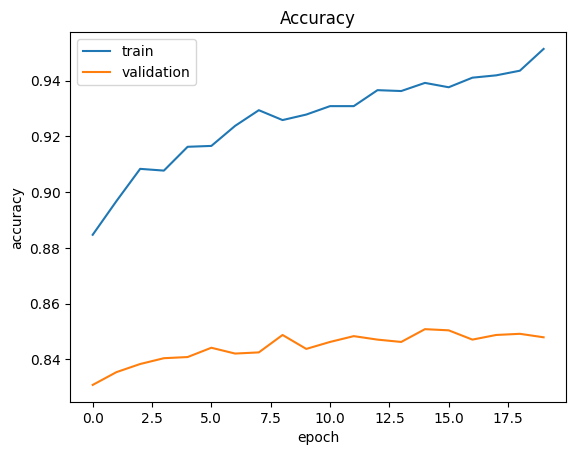

In [33]:
def plot_hist(hist):
    plt.plot(hist.history['accuracy'])
    plt.plot(hist.history['val_accuracy'])
    plt.title('Accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

plot_hist(history)

The vanishing gradient problem is solved. Although there is overfitting, it is not very serious, and the model performance seems to be good.

---

### Trail number4. Xception_4

* For Trail number 4, I decide to use excatly the same model as trail number 1 but with more data augmentation.

In [153]:
train_set2, valid_set, test_set = tfds.load(
    name="stanford_dogs",
    split=["train[:80%]", "train[80%:]", "test"],
    as_supervised=True
    )

data_augmentation2 = tf.keras.Sequential([
    tf.keras.layers.RandomFlip(mode="horizontal", seed=42),
    tf.keras.layers.RandomRotation(factor=0.3, seed=42),
    tf.keras.layers.RandomHeight(0.2, seed=42),
    tf.keras.layers.RandomWidth(0.2, seed=42),
    tf.keras.layers.RandomZoom(0.1, seed=42)
])

train_set2 = (
    train_set2
    .map(lambda x, y: (preprocess(x), y))
    .shuffle(batch_size * 100)
    .batch(batch_size)
    .map(lambda x, y: (data_augmentation2(x), y), num_parallel_calls=tf.data.AUTOTUNE)  # Corrected here
    .prefetch(tf.data.AUTOTUNE)
)

valid_set = (
    valid_set
    .map(lambda x, y: (preprocess (x), y))
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)


test_set = (
    test_set
    .map(lambda x, y: (preprocess (x), y))
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)

Displays 9 images after augmentation

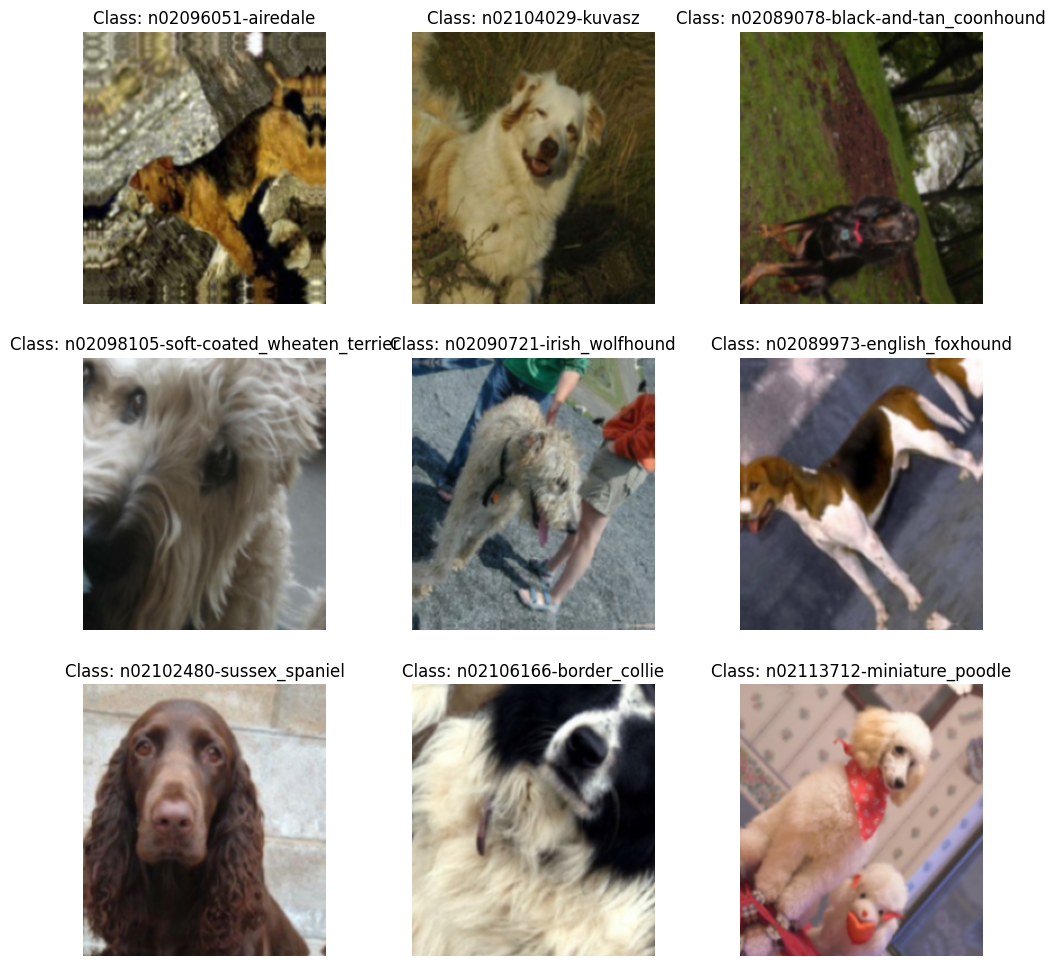

In [154]:
plt.figure(figsize=(12, 12))
for X_batch, y_batch in train_set2.take(1):
    X_batch_augmented = data_augmentation2(X_batch, training=True)
    for index in range(9):
        plt.subplot(3, 3, index + 1)
        # We must rescale the images to the 0-1 range for imshow(), and also
        # clip the result to that range, because data augmentation may
        # make some values go out of bounds (e.g., RandomContrast in this case).
        plt.imshow(np.clip((X_batch_augmented[index] + 1) / 2, 0, 1))
        plt.title(f"Class: {class_names[y_batch[index]]}")
        plt.axis("off")

plt.show()

In [155]:
tf.keras.backend.clear_session()

In [156]:
base_model = tf.keras.applications.xception.Xception(weights="imagenet", include_top=False)

tf.random.set_seed(42)

#Average Pooling Layer
avg = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)

#Dense Output Layer
output = tf.keras.layers.Dense(n_classes, activation="softmax")(avg)

model = tf.keras.Model(inputs = base_model.input, outputs = output)

In [157]:
for layer in base_model.layers:
    layer.trainable = False

In [159]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.9)
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=["accuracy"])

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("xception_checkpoints4", save_best_only=True)
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

history = model.fit(train_set2, validation_data=valid_set, epochs=5, callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/5
300/300 [==============================] - ETA: 0s - loss: 2.8305 - accuracy: 0.4771

INFO:tensorflow:Assets written to: xception_checkpoints4\assets


INFO:tensorflow:Assets written to: xception_checkpoints4\assets


300/300 [==============================] - 693s 2s/step - loss: 2.8305 - accuracy: 0.4771 - val_loss: 1.1632 - val_accuracy: 0.7667
Epoch 2/5
300/300 [==============================] - ETA: 0s - loss: 2.3930 - accuracy: 0.5820

INFO:tensorflow:Assets written to: xception_checkpoints4\assets


INFO:tensorflow:Assets written to: xception_checkpoints4\assets


300/300 [==============================] - 561s 2s/step - loss: 2.3930 - accuracy: 0.5820 - val_loss: 1.0516 - val_accuracy: 0.7908
Epoch 3/5
300/300 [==============================] - 535s 2s/step - loss: 2.3107 - accuracy: 0.5940 - val_loss: 1.1629 - val_accuracy: 0.7896
Epoch 4/5
300/300 [==============================] - 535s 2s/step - loss: 2.1617 - accuracy: 0.6197 - val_loss: 1.1645 - val_accuracy: 0.7879
Epoch 5/5
300/300 [==============================] - 557s 2s/step - loss: 2.0730 - accuracy: 0.6301 - val_loss: 1.1715 - val_accuracy: 0.7875


In [160]:
for layer in model.layers[56:]:
    if not isinstance(layer, tf.keras.layers.BatchNormalization): #Nornalization layer need to remain frozen
        layer.trainable = True

In [162]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.0001, momentum=0.9)
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=["accuracy"])

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("xception_checkpoints_4", save_best_only=True)
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

history = model.fit(train_set2, validation_data=valid_set, epochs=50, callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/50
300/300 [==============================] - ETA: 0s - loss: 1.0579 - accuracy: 0.7237

INFO:tensorflow:Assets written to: xception_checkpoints_4\assets


INFO:tensorflow:Assets written to: xception_checkpoints_4\assets


300/300 [==============================] - 1435s 5s/step - loss: 1.0579 - accuracy: 0.7237 - val_loss: 0.6483 - val_accuracy: 0.8263
Epoch 2/50
300/300 [==============================] - ETA: 0s - loss: 0.9049 - accuracy: 0.7489

INFO:tensorflow:Assets written to: xception_checkpoints_4\assets


INFO:tensorflow:Assets written to: xception_checkpoints_4\assets


300/300 [==============================] - 1424s 5s/step - loss: 0.9049 - accuracy: 0.7489 - val_loss: 0.6128 - val_accuracy: 0.8279
Epoch 3/50
300/300 [==============================] - ETA: 0s - loss: 0.8279 - accuracy: 0.7659

INFO:tensorflow:Assets written to: xception_checkpoints_4\assets


INFO:tensorflow:Assets written to: xception_checkpoints_4\assets


300/300 [==============================] - 1392s 5s/step - loss: 0.8279 - accuracy: 0.7659 - val_loss: 0.6058 - val_accuracy: 0.8317
Epoch 4/50
300/300 [==============================] - ETA: 0s - loss: 0.7421 - accuracy: 0.7837

INFO:tensorflow:Assets written to: xception_checkpoints_4\assets


INFO:tensorflow:Assets written to: xception_checkpoints_4\assets


300/300 [==============================] - 1446s 5s/step - loss: 0.7421 - accuracy: 0.7837 - val_loss: 0.6000 - val_accuracy: 0.8367
Epoch 5/50
300/300 [==============================] - 1443s 5s/step - loss: 0.7329 - accuracy: 0.7850 - val_loss: 0.6013 - val_accuracy: 0.8354
Epoch 6/50
300/300 [==============================] - 1385s 5s/step - loss: 0.7061 - accuracy: 0.7895 - val_loss: 0.6013 - val_accuracy: 0.8354
Epoch 7/50
300/300 [==============================] - 1387s 5s/step - loss: 0.6932 - accuracy: 0.7934 - val_loss: 0.6003 - val_accuracy: 0.8392
Epoch 8/50
300/300 [==============================] - 1387s 5s/step - loss: 0.6724 - accuracy: 0.8021 - val_loss: 0.6005 - val_accuracy: 0.8396
Epoch 9/50
300/300 [==============================] - ETA: 0s - loss: 0.6662 - accuracy: 0.8079

INFO:tensorflow:Assets written to: xception_checkpoints_4\assets


INFO:tensorflow:Assets written to: xception_checkpoints_4\assets


300/300 [==============================] - 1409s 5s/step - loss: 0.6662 - accuracy: 0.8079 - val_loss: 0.5901 - val_accuracy: 0.8333
Epoch 10/50
300/300 [==============================] - 1446s 5s/step - loss: 0.6246 - accuracy: 0.8155 - val_loss: 0.5970 - val_accuracy: 0.8358
Epoch 11/50
300/300 [==============================] - 1401s 5s/step - loss: 0.6390 - accuracy: 0.8101 - val_loss: 0.6041 - val_accuracy: 0.8371
Epoch 12/50
300/300 [==============================] - 1392s 5s/step - loss: 0.6062 - accuracy: 0.8131 - val_loss: 0.5936 - val_accuracy: 0.8329
Epoch 13/50
300/300 [==============================] - 1429s 5s/step - loss: 0.5792 - accuracy: 0.8285 - val_loss: 0.5968 - val_accuracy: 0.8350
Epoch 14/50
300/300 [==============================] - 1452s 5s/step - loss: 0.5620 - accuracy: 0.8266 - val_loss: 0.6040 - val_accuracy: 0.8363
Epoch 15/50
300/300 [==============================] - 1464s 5s/step - loss: 0.5633 - accuracy: 0.8319 - val_loss: 0.5977 - val_accuracy: 0.83

In [164]:
model.save("xception_4", save_format = "tf")

INFO:tensorflow:Assets written to: xception_4\assets


INFO:tensorflow:Assets written to: xception_4\assets


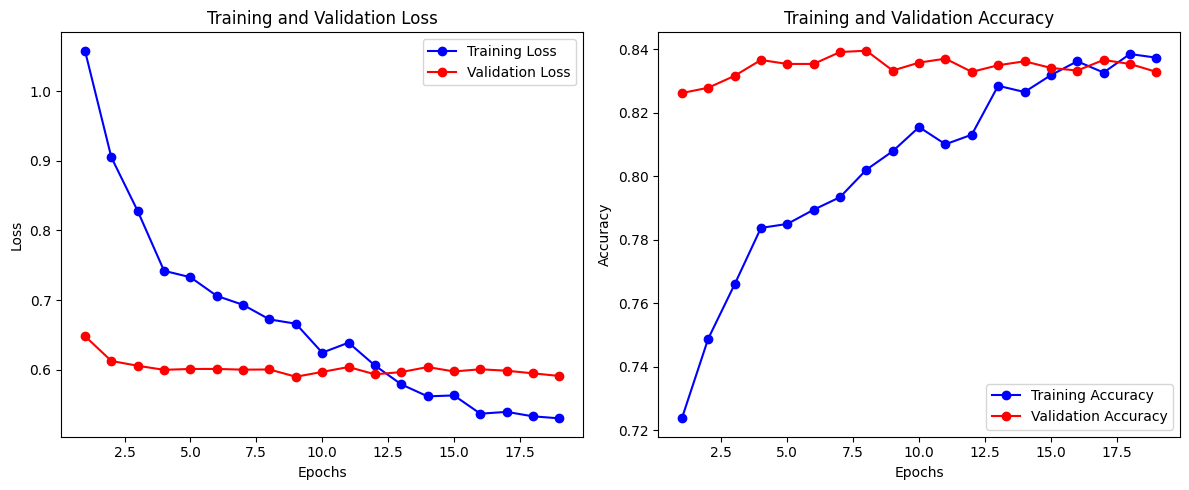

In [166]:
# Access the training history
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

# Create a range of epochs
epochs = range(1, len(training_loss) + 1)

# Plot training and validation loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, training_loss, 'bo-', label='Training Loss')
plt.plot(epochs, validation_loss, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, training_accuracy, 'bo-', label='Training Accuracy')
plt.plot(epochs, validation_accuracy, 'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

According to the learning curve, the validation dataset does not provide sufficient information to evaluate the ability of the model to generalize. However,  our validation set is more in line with real-world pictures, and there are enough data, so I think there is too much data augmentation for the train set. 

----

## Experiment Conclusion

In [151]:
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', -1)
experiment = pd.read_excel( "experiment record.xlsx")
experiment 

C:\Users\Jonathan\AppData\Local\Temp\ipykernel_18636\2792375035.py:3: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('max_colwidth', -1)


trail number                                                                                                                        Purpose trail name(model saved name)                                                                                                                                                                data augmentation                                                                                                                                     additional layers                            output layer unfreeze layers for fine-tuning          unfreaze layers discription  train accuracy before fine-tuning(5 epochs)  valid accuracy before fine-tuning(5 epochs)  train accuracy after fine-tuning  valid accuracy after fine-tuning Summary from learning curve                                                                                                     Summary of model
0  0             Building a base-line model with Xception                                                                                       xception_0                   RandomFlip(mode="horizontal", seed=42), \nRandomRotation(factor=0.05, seed=42)                                                                                                   GlobalAveragePooling2D()                                                                                                                              Dense(n_classes, activation="softmax")  layers[116:]                    start of residual unit 13 out of 14  0.8827                                       0.8204                                       0.9404                            0.8458                            minimal overfitting         The model fits pretty well.                                                                                        
1  1             Unfreeze more layers of the base model when fine-tuning                                                                        xception_1                   RandomFlip(mode="horizontal", seed=42), \nRandomRotation(factor=0.05, seed=42)                                                                                                   GlobalAveragePooling2D()                                                                                                                              Dense(n_classes, activation="softmax")  layers[56:]                     start of residual unit 7 out of 14   0.8827                                       0.8204                                       0.9733                            0.8438                            overfitting                 performance decrease                                                                                               
2  2             Adding more layers on top of the Xception                                                                                      xception_2                   RandomFlip(mode="horizontal", seed=42), \nRandomRotation(factor=0.05, seed=42)\n                                                                                                 GlobalAveragePooling2D(), \nFlatten(),\nDropout(0.3),\nDense(512, activation= "relu"),\nDense(512, activation= "relu")                                Dense(n_classes, activation="softmax")  NaN                             NaN                                  0.6662                                       0.7246                                      NaN                               NaN                                underfitting                1. No fine-tuning implemented.\n2. Vanishing gradient problem.                                                     
3  3             Using the trail num 2 model with batch normalization layers in the additional layers\n(To pretend vanishing gradient problem)  xception_3                   RandomFlip(mode="horizontal", seed=42), \nRandomRotation(factor=0.05, seed=42)                                                                                                   GlobalAve

Both xception_0 and xception_3 perform well, but xception_0 is relatively simple, so I plan to use xception_0 as my final model

---

## Testing Model

In [152]:
my_model = tf.keras.models.load_model('xception_0')

### Testing on the testing set

In [156]:
test_loss, test_accuracy = my_model.evaluate(test_set)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

269/269 [==============================] - 316s 1s/step - loss: 0.7584 - accuracy: 0.8437
Test Loss: 0.7584273219108582
Test Accuracy: 0.8437063097953796


### Testing on my own data

1/1 [==============================] - 1s 1s/step


Predicted Breed: n02096051-airedale


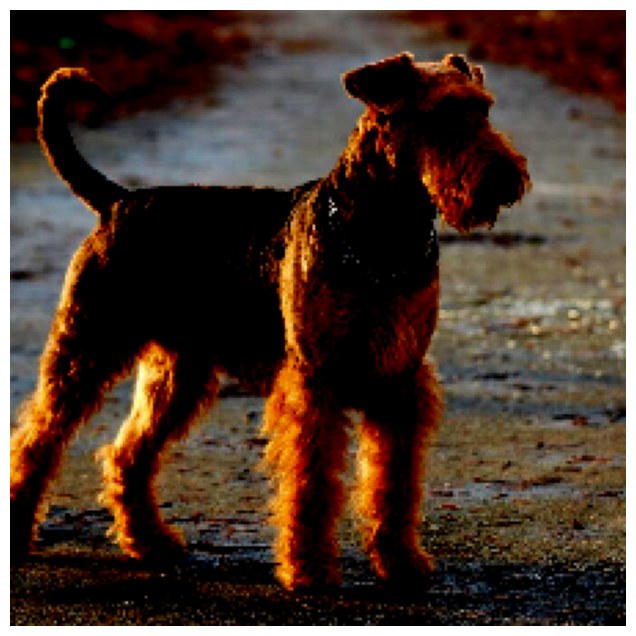

1/1 [==============================] - 0s 179ms/step


Predicted Breed: n02105251-briard


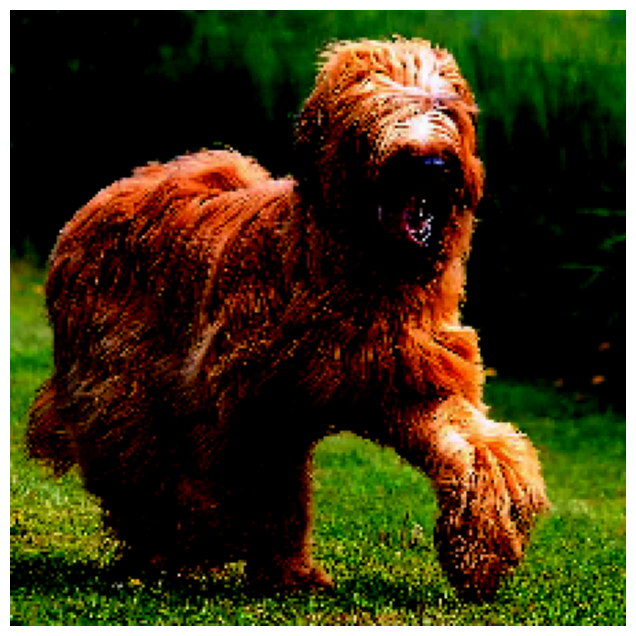

1/1 [==============================] - 0s 188ms/step


Predicted Breed: n02115641-dingo


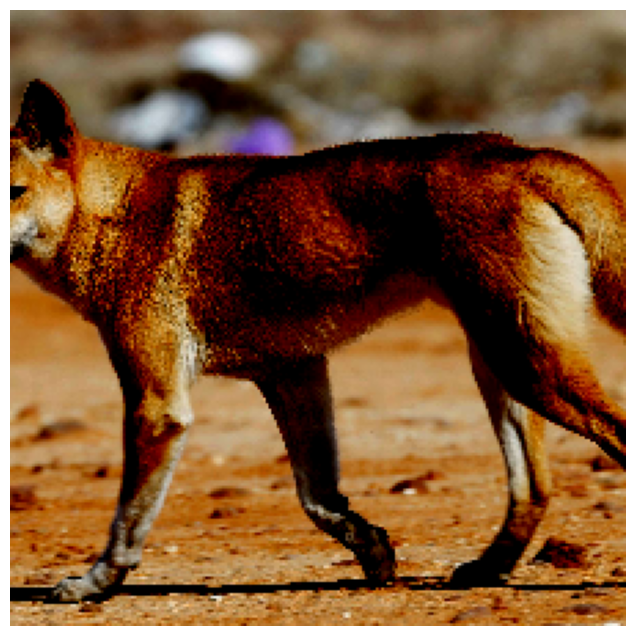

1/1 [==============================] - 0s 156ms/step


Predicted Breed: n02100735-english_setter


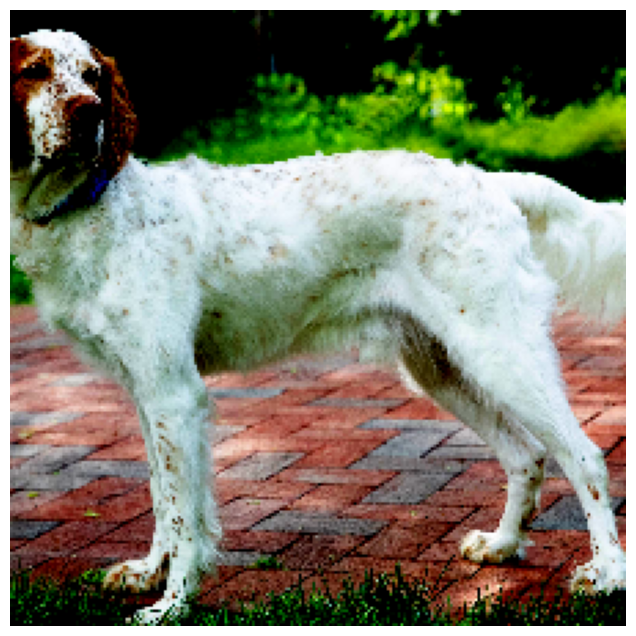

1/1 [==============================] - 0s 102ms/step


Predicted Breed: n02112018-pomeranian


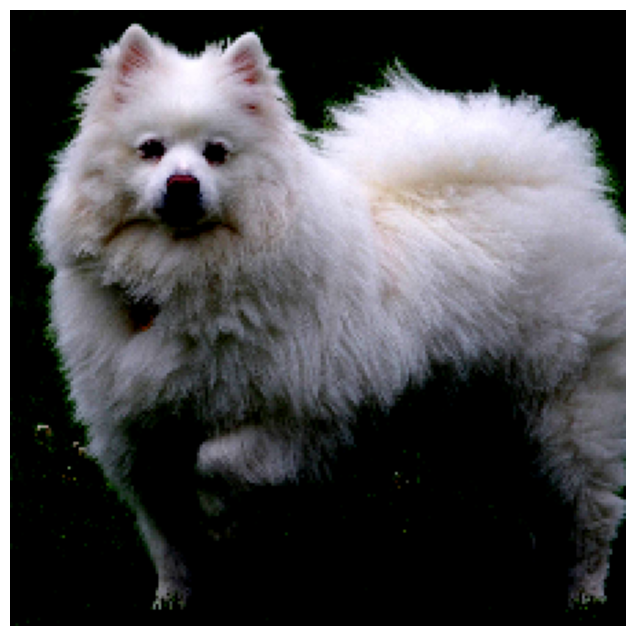

1/1 [==============================] - 0s 229ms/step


Predicted Breed: n02091032-italian_greyhound


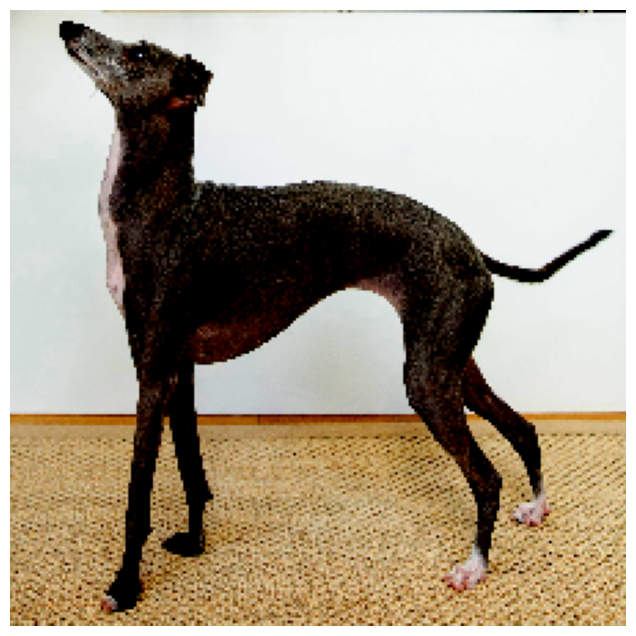

1/1 [==============================] - 0s 134ms/step


Predicted Breed: n02091032-italian_greyhound


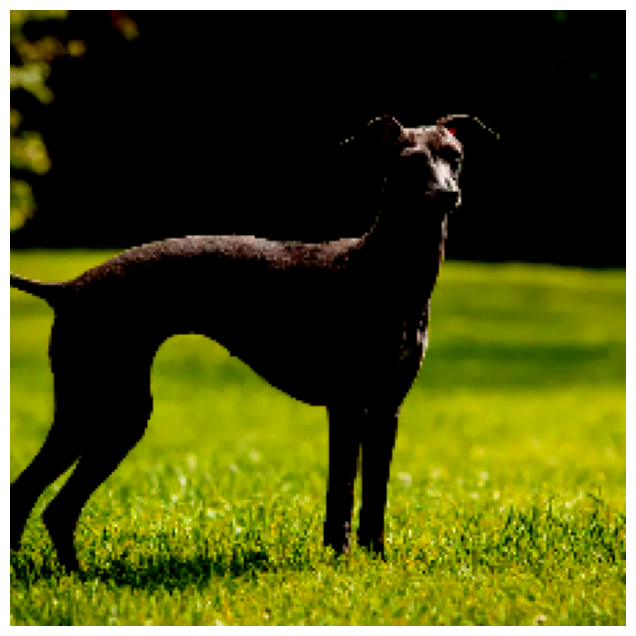

1/1 [==============================] - 0s 154ms/step


Predicted Breed: n02113978-mexican_hairless


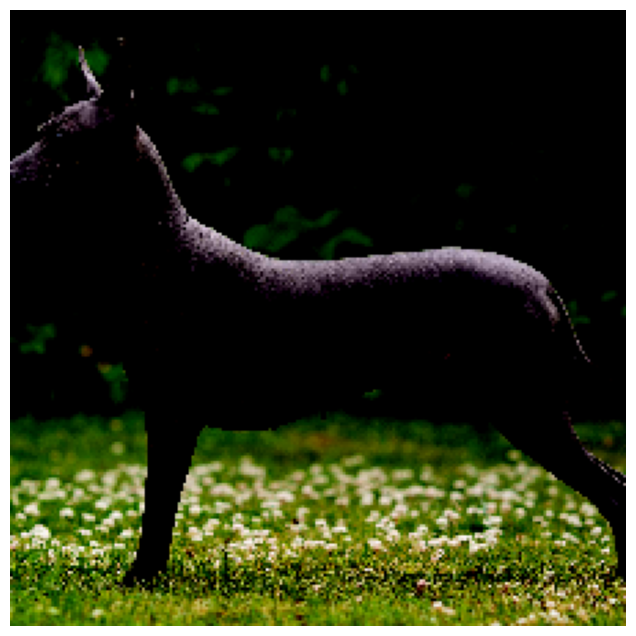

1/1 [==============================] - 0s 143ms/step


Predicted Breed: n02113978-mexican_hairless


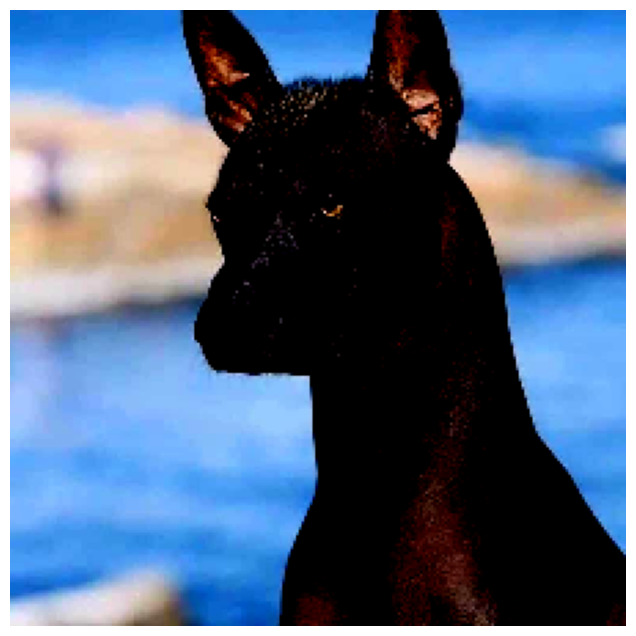

1/1 [==============================] - 0s 165ms/step


Predicted Breed: n02113624-toy_poodle


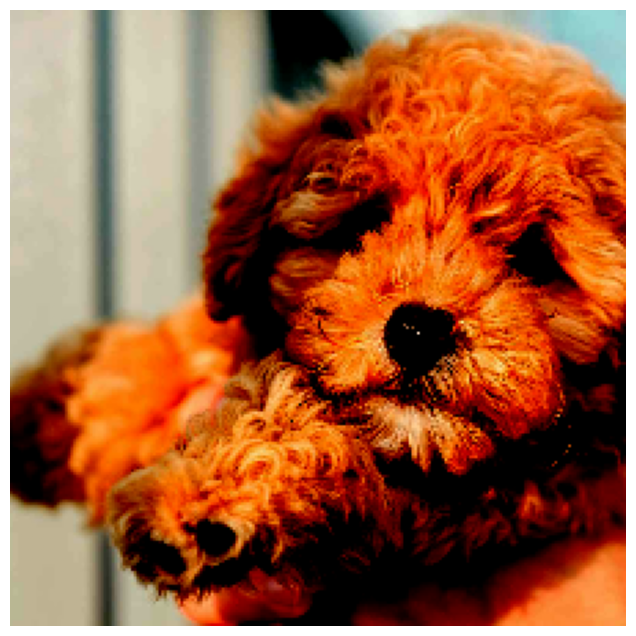

In [226]:
# Set the path to your testing images folder
testing_images_folder = "my_testing_images"

# List all files in the folder
image_files = [f for f in os.listdir(testing_images_folder) if os.path.isfile(os.path.join(testing_images_folder, f))]

preprocessed_images = []

for image_file in image_files:
    try:
        # Open the image using PIL
        image_path = os.path.join(testing_images_folder, image_file)
        img = image.load_img(image_path)
        img = tf.keras.layers.Resizing(height = 224, width = 224, crop_to_aspect_ratio = True)(img)
        img = tf.keras.applications.xception.preprocess_input(img)
        
        inputs  = tf.expand_dims( img , axis=0)
        preprocessed_images.append(inputs)
        
    except Exception as e:
        print(f"Error loading {image_file}: {str(e)}")
    

for idx, preprocessed_image in enumerate(preprocessed_images):
    predictions = my_model.predict(preprocessed_image)
    predicted_class_index = np.argmax(predictions)
    predicted_class_label = f'Class {predicted_class_index}'
    breed_names = info.features['label'].names
    predicted_breed_name = breed_names[predicted_class_index]
    
    plt.figure(figsize=(8, 8))
    plt.imshow(preprocessed_image[0]) 
    plt.axis('off')

    print(f'Predicted Breed: {predicted_breed_name}')

    plt.show()
    

---

## Deploy the model using Streamlit

In [232]:
%%writefile app.py
import streamlit as st
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.applications.xception import preprocess_input
dataset, info = tfds.load("stanford_dogs", as_supervised=True, with_info=True)

st.set_option('deprecation.showfileUploaderEncoding', False)
@st.cache(allow_output_mutation = True)
def load_model():
    model = tf.keras.models.load_model('xception_0')
    return model
model = load_model()
st.write("""
    # Dog Breed Classification
         """
)

def main():
    file = st.file_uploader("Please upload an doggy image", type = ["jpg", "png"])
    import cv2
    from PIL import Image, ImageOPS
    import numpy as np
    def import_and_predict(image_data, model):
        img = tf.keras.layers.Resizing(height = 224, width = 224, crop_to_aspect_ratio = True)(image_data)
        img = tf.keras.applications.xception.preprocess_input(img)
        inputs  = tf.expand_dims( img , axis=0) 
        predictions = model.predict(inputs)
        return predictions

    if file is None:
        st.text("Please upload an image file")
    else:
        image = Image.open(file)
        st.image(image, use column_width=True)
        predictions = import_and_predict(image, model)
        predicted_class_index = np.argmax(predictions)
        predicted_class_label = f'Class {predicted_class_index}'
        breed_names = info.features['label'].names
        predicted_breed_name = breed_names[predicted_class_index]
        string = "This image most likely is: "+predicted_breed_name 
        st.success(string)
    
if __name__ == '__main__':
    main()

Overwriting app.py
